# Final Project NLP - SMALL VERSION
Erik Buunk | 
Aug 2020

> This is the modified version for the grader to run
> Including a simplified deployment in at the end


# Part 1: Notebook 02 - Data exploration 

The purpose of this note book to get acquinted with the data to know which operations were needed for the final dataset. 
Also a baseline performance was done, from which further development of the model was determined.


## Data files:

Part 1
- metal_songs.csv
- artist-data.csv
- lyrics-data.csv

Part 2
- X_test.pkl.gz
- X_train.pkl.gz
- y_test.pkl.gz
- y_train.pkl.gz

Part 3:
- final_lyrics_model.pkl.gz

If you are not running on COLAB you need: 
- lyrics_bert_vectors_train.pkl.gz
- lyrics_bert_vectors_val.pkl.gz'
- lyrics_bert_vectors_test.pkl.gz'



## Settings:
- set `COLAB = True` if you run this on Colab. Data can be placed in the root 
directory

Pleas Note: Colab is extremely unstable. It seems impossibel the run all the cells with `Run all` without crashing, hanging on certain cells or other hickups. Manually running cells one by one is most of the times the best solution but no guarantee that every will work :(

In [1]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
from numpy import log, mean, matmul


required = {'spacy', 'scikit-learn', 'numpy', 
            'pandas', 'torch', 'matplotlib',
            'transformers', 'allennlp==0.9.0'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
import spacy
import numpy as np
import pandas as pd

# SciKit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# Spacy
from spacy.lang.en import English
en = English()

# !python -m spacy download en_core_web_md # includes GloVe Vectors
# !python -m spacy download en_core_web_sm
# !python -m spacy download en

# import en_core_web_sm
# import en_core_web_md


# PyTorch
import torch
# import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# File managment
import os
from os import listdir
from pathlib import Path
import pickle
import gzip


In [2]:
LOAD_DATA = False # read save data or regenerate data
SAVE_DATA = False # overwrite generated data? 

COLAB = True

In [3]:
if COLAB:
  # Google Colab
  path = "./"
  device = torch.device("cuda:0") # use GPU, change 
else:
  # Laptop
  path = "./data/"
  device = torch.device("cpu")
#   !pip install ipywidgets
#   !jupyter nbextension enable --py widgetsnbextension


# Functions

In [4]:
def show_data():
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          print(os.path.join(dirname, filename))

# show_data()

In [5]:
def save_pickle(filename, data):
    with open(f"{path}{filename}", "wb") as fp: 
      pickle.dump(data, fp)

def load_pickle(filename):
    with open(f"{path}{filename}", 'rb') as f:
      return pickle.load(f)
    
def save_file(filename, train_tokens, test_tokens, val_tokens):
  data = {"train_tokens": train_tokens, "test_tokens" : test_tokens, "val_tokens": val_tokens}

  with open(f"{path}{filename}", "wb") as fp: 
    pickle.dump(data, fp)
    
def load_file(filename):
  with open(f"{path}{filename}", 'rb') as f:
      all_text = pickle.load(f)
      return (all_text["train_tokens"], all_text["test_tokens"], all_text["val_tokens"])


In [6]:
def split_train_val_test (X, y, pct_train = 0.7, pct_val = 0.3):
  np.random.seed(0)
  train_bool = np.random.random(len(X)) <= pct_train
  x_train = X[train_bool]
  y_train = y[train_bool]

  x_test = X[~train_bool]
  y_test = y[~train_bool]

  # split the training 30% for validation
  val_bool = np.random.random(size=len(x_train)) <= pct_val
  x_val = x_train[val_bool]
  y_val = y_train[val_bool]

  # exclude validation from training
  x_train = x_train[~val_bool]
  y_train = y_train[~val_bool]
  
  #check lengths
  print("Training: ", len(x_train), len(y_train))
  print("Validation: ", len(x_val), len(y_val))
  print("Test: ", len(x_test), len(y_test))
  
  return x_train, y_train, x_val, y_val, x_test, y_test

# Load Data

In [7]:
# if LOAD_DATA:
#   df_total = pd.read_csv(f'{path}df_total.csv')
#   df_small = pd.read_pickle(f'{path}df_small.pkl.gz')
#   (x_test, x_val, x_test, y_train, y_val, y_test) = load_pickle('data_split_sm.pkl') # based on the sampled small data set

#   lyrics_bert_vectors_train = pd.read_pickle(f'{path}lyrics_bert_vectors_train.pkl.gz')
#   lyrics_bert_vectors_val = pd.read_pickle(f'{path}lyrics_bert_vectors_val.pkl.gz')
#   lyrics_bert_vectors_test = pd.read_pickle(f'{path}lyrics_bert_vectors_test.pkl.gz')

  
# # TODO: part of the data preparation can be skipped here of the data is pre-loaded

In [8]:
# Read data
df_artist =  pd.read_csv(f'{path}artists-data.csv')

In [9]:
df_lyrics = pd.read_csv(f'{path}lyrics-data.csv')

In [10]:
df_metal = pd.read_csv(f'{path}metal_songs.csv')

# Data exploration and data preparation


In [11]:
print(df_artist.columns)
print(df_lyrics.columns)
print(df_metal.columns)

Index(['Artist', 'Songs', 'Popularity', 'Link', 'Genre', 'Genres'], dtype='object')
Index(['ALink', 'SName', 'SLink', 'Lyric', 'Idiom'], dtype='object')
Index(['Genre', 'Artist', 'Song', 'Lyric'], dtype='object')


#### Lyrics

In [12]:
df_lyrics.shape

(50000, 5)

In [13]:
df_lyrics["Idiom"].value_counts().head(n=10)

ENGLISH        27229
PORTUGUESE     20507
SPANISH         1100
ITALIAN          145
FRENCH           121
GERMAN            72
KINYARWANDA       16
ESTONIAN           5
SWEDISH            5
INDONESIAN         4
Name: Idiom, dtype: int64

For this project we will use English only.

In [14]:
df_lyrics_en = df_lyrics.query("Idiom == 'ENGLISH'")
df_lyrics_en = df_lyrics_en.drop(["SLink", "Idiom"], axis=1)
df_lyrics_en.shape

(27229, 3)

In [15]:
df_lyrics_en

,ALink,SName,Lyric
0,/ace-hood/,We On,"Okay. Uh, okay I walked in the party and it's ..."
2,/foxy-brown/,The Chase,"Uhhhh yeahhhh uh, The Firm. Lust... hate... en..."
3,/nick-jonas/,Avalanche (Feat. Demi Lovato),Words like a loaded gun. Shot out from a fire ...
6,/sonic-youth/,Wildflower Soul,sing yr children. yr children song. sing yr lo...
7,/tarja-turunen/,I Walk Alone,Put all your angels on the edge. Keep all the ...
...,...,...,...
49992,/fleetwood-mac/,Welcome To The Room... Sara,Written by Stevie Nicks.. . It's not home. And...
49993,/b-o-b/,Grand Hustle Kings (Feat. Young Dro & T.i.),I'll be questioning ain't gonna be … hold up. ...
49994,/avenged-sevenfold/,An Epic of Time Wasted,So much time I've wasted.. I can truly say I n...
49996,/shanell/,Cha-Ching (Feat. Millionaires),[Hook]. Cha-ching. Cha-ching. Let me here you ...


#### Artist

In [16]:
# origianl query:
df_artist_sm = df_artist.query("Genre == 'Rock' | Genre == 'Pop' | Genre == 'Hip Hop'")

# 2 category:
# df_artist_sm = df_artist.query("Genre == 'Rock' | Genre == 'Hip Hop'")

total = df_artist_sm.shape[0]
100*df_artist_sm["Genre"].value_counts()/total

Rock       37.417840
Pop        37.370892
Hip Hop    25.211268
Name: Genre, dtype: float64

In [17]:
# original
genres = ["Rock", "Pop", "Hip Hop"]

# 2 category
# genres = ["Rock", "Hip Hop", "Metal"]
genres.sort()

total_songs = df_artist_sm["Songs"].sum()
print(f"Total Songs: {total_songs}")
for i in genres:
    percentage = round(100*df_artist_sm[df_artist_sm.Genre == i]["Songs"].sum()/total_songs, 2 )
    print(f"{i} {percentage}%")

Total Songs: 127523
Hip Hop 17.03%
Pop 34.15%
Rock 48.82%


In [18]:
df_artist_sm_red = df_artist_sm.drop(["Genres", "Popularity", "Songs"], axis = 1)

In [19]:
df_artist_sm_red

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock
1,12 Stones,/12-stones/,Rock
2,311,/311/,Rock
3,4 Non Blondes,/4-non-blondes/,Rock
4,A Cruz Está Vazia,/a-cruz-esta-vazia/,Rock
...,...,...,...
3227,Tati Quebra Barraco,/tati-quebra-barraco/,Hip Hop
3228,Valesca Popozuda,/valesca-popozuda/,Pop
3229,Vine Rodry,/vine-rodry/,Pop
3234,Leandro Sapucahy,/leandro-sapucahy/,Pop


In [20]:
# Remove duplicate Link values

# pd.DataFrame(df_artist_sm["Link"].value_counts())
(df_artist_sm_red["Link"].value_counts() > 1).sum()

144

In [21]:
# drop duplicates
df_artist_dedup = df_artist_sm_red.drop(df_artist_sm_red[df_artist_sm_red.Link.duplicated()].index)

In [22]:
# Some artist have multiple genrese. These are removed.

(df_artist_dedup["Link"].value_counts() > 1).sum()
df_artist_dedup[df_artist_dedup["Artist"] =='10000 Maniacs']

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock


#### Metal lyrics

In [23]:
df_metal = pd.read_csv(f'{path}metal_songs.csv')
df_metal.head()

,Genre,Artist,Song,Lyric
0,Metal,Melvins,Hdyf,\n
1,Metal,Zakk Wylde,I Thank You Child,All for you\nEverlasting love forever skies of...
2,Metal,Zemial,In The Arms Of Hades,Black winged demons haunt the dungeons where t...
3,Metal,Znowhite,War Machine,Youâre no stranger\nYouâve been this way b...
4,Metal,Melvins,Dry Drunk,\n


In [24]:
# drop instrumental songs
df_metal = df_metal[df_metal["Lyric"]!= ' Instrumental   ']
df_metal

,Genre,Artist,Song,Lyric
0,Metal,Melvins,Hdyf,\n
1,Metal,Zakk Wylde,I Thank You Child,All for you\nEverlasting love forever skies of...
2,Metal,Zemial,In The Arms Of Hades,Black winged demons haunt the dungeons where t...
3,Metal,Znowhite,War Machine,Youâre no stranger\nYouâve been this way b...
4,Metal,Melvins,Dry Drunk,\n
...,...,...,...,...
1870,Metal,Melvins,Prig,All the hand and other land\nAnd all I've done...
1871,Metal,Damageplan,Breathing New Life,CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...
1872,Metal,Zimmer S Hole,Anonymous Esophagus,Anonymous Esophagus\nYou love to scream and sh...
1873,Metal,Melvins,You Ve Never Been Right,"The rabies, and what we think is right\nWe're ..."


In [25]:
df_metal = df_metal[~df_metal["Lyric"].isnull()]

In [26]:
l = df_metal["Lyric"].apply(lambda x: x.strip())
l

0                                                        
1       All for you\nEverlasting love forever skies of...
2       Black winged demons haunt the dungeons where t...
3       Youâre no stranger\nYouâve been this way b...
4                                                        
                              ...                        
1870    All the hand and other land\nAnd all I've done...
1871    CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...
1872    Anonymous Esophagus\nYou love to scream and sh...
1873    The rabies, and what we think is right\nWe're ...
1874    If the end be a comin'\nI soon be a bummin'\nA...
Name: Lyric, Length: 1875, dtype: object

In [27]:
df_metal = df_metal[l!='']

In [28]:
df_metal2 = pd.DataFrame({"SName" : df_metal["Song"],	
                          "Lyric": df_metal["Lyric"],  	
                          "Artist" : df_metal["Artist"],  	
                          "Genre": df_metal["Genre"]})
                         
                       
                         
df_metal2                         

,SName,Lyric,Artist,Genre
1,I Thank You Child,All for you\nEverlasting love forever skies of...,Zakk Wylde,Metal
2,In The Arms Of Hades,Black winged demons haunt the dungeons where t...,Zemial,Metal
3,War Machine,Youâre no stranger\nYouâve been this way b...,Znowhite,Metal
6,The Frontiersman,I dream of a new life\nAn oath that's to repay...,Damnation Angels,Metal
7,V,I don't want to be blind\nI don't want to be t...,Zeromancer,Metal
...,...,...,...,...
1870,Prig,All the hand and other land\nAnd all I've done...,Melvins,Metal
1871,Breathing New Life,CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...,Damageplan,Metal
1872,Anonymous Esophagus,Anonymous Esophagus\nYou love to scream and sh...,Zimmer S Hole,Metal
1873,You Ve Never Been Right,"The rabies, and what we think is right\nWe're ...",Melvins,Metal


#### Join the data

In [29]:
# join the two data frames
df_lyrics_prejoin = df_lyrics_en.set_index('ALink')
df_artist_prejoin = df_artist_dedup.set_index('Link')
df_total = df_lyrics_prejoin.join(df_artist_prejoin)

In [30]:
# check that the join is correct
df_total.shape

(27229, 4)

In [31]:
df_total

,SName,Lyric,Artist,Genre
/10000-maniacs/,Sally Ann,A woman of beauty. A woman of pain. In france ...,10000 Maniacs,Rock
/10000-maniacs/,Hidden In My Heart,"Music by 10,000 Maniacs - Lyrics by Mary Ramse...",10000 Maniacs,Rock
/10000-maniacs/,Poison In The Well,[ music: Dennis Drew/words: Natalie Merchant ]...,10000 Maniacs,Rock
/10000-maniacs/,Who Knows Where The Time Goes?,"Across the evening sky, all the birds are leav...",10000 Maniacs,Rock
/10000-maniacs/,"To Sir, With Love",[original version by Lulu]. Those schoolgirl d...,10000 Maniacs,Rock
...,...,...,...,...
/zz-top/,"Neighbor, Neighbor","Words and music by Billy Gibbons.. Neighbor, n...",ZZ Top,Rock
/zz-top/,Gun Love,"She likes to shoot her gun,. Shootin' at the t...",ZZ Top,Rock
/zz-top/,Poke Chop Sandwitch,(about lightnin' hopkins' drummer who used to ...,ZZ Top,Rock
/zz-top/,Thunderbird,"Get high, everybody, get high.. Get high, ever...",ZZ Top,Rock


In [32]:
# drop na values that couldn't be matched
df_total = df_total[~df_total["Genre"].isnull()]
df_total

,SName,Lyric,Artist,Genre
/10000-maniacs/,Sally Ann,A woman of beauty. A woman of pain. In france ...,10000 Maniacs,Rock
/10000-maniacs/,Hidden In My Heart,"Music by 10,000 Maniacs - Lyrics by Mary Ramse...",10000 Maniacs,Rock
/10000-maniacs/,Poison In The Well,[ music: Dennis Drew/words: Natalie Merchant ]...,10000 Maniacs,Rock
/10000-maniacs/,Who Knows Where The Time Goes?,"Across the evening sky, all the birds are leav...",10000 Maniacs,Rock
/10000-maniacs/,"To Sir, With Love",[original version by Lulu]. Those schoolgirl d...,10000 Maniacs,Rock
...,...,...,...,...
/zz-top/,"Neighbor, Neighbor","Words and music by Billy Gibbons.. Neighbor, n...",ZZ Top,Rock
/zz-top/,Gun Love,"She likes to shoot her gun,. Shootin' at the t...",ZZ Top,Rock
/zz-top/,Poke Chop Sandwitch,(about lightnin' hopkins' drummer who used to ...,ZZ Top,Rock
/zz-top/,Thunderbird,"Get high, everybody, get high.. Get high, ever...",ZZ Top,Rock


In [33]:
# add metal dataset
df_total = df_total.append(df_metal2, ignore_index=True)
df_total

,SName,Lyric,Artist,Genre
0,Sally Ann,A woman of beauty. A woman of pain. In france ...,10000 Maniacs,Rock
1,Hidden In My Heart,"Music by 10,000 Maniacs - Lyrics by Mary Ramse...",10000 Maniacs,Rock
2,Poison In The Well,[ music: Dennis Drew/words: Natalie Merchant ]...,10000 Maniacs,Rock
3,Who Knows Where The Time Goes?,"Across the evening sky, all the birds are leav...",10000 Maniacs,Rock
4,"To Sir, With Love",[original version by Lulu]. Those schoolgirl d...,10000 Maniacs,Rock
...,...,...,...,...
27670,Prig,All the hand and other land\nAnd all I've done...,Melvins,Metal
27671,Breathing New Life,CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...,Damageplan,Metal
27672,Anonymous Esophagus,Anonymous Esophagus\nYou love to scream and sh...,Zimmer S Hole,Metal
27673,You Ve Never Been Right,"The rabies, and what we think is right\nWe're ...",Melvins,Metal


In [34]:
#TODO: Sort by Genre so we know the splits in the data for cosine similarities
df_total = df_total.sort_values(ascending=True, by="Genre")
df_total = df_total.reset_index()
df_total = df_total.drop(["index"], axis=1)

In [35]:
df_total

,SName,Lyric,Artist,Genre
0,"Uptown (Feat. Nesby Phips, Reem & Juvenile)","[Verse 1:]. She tap, the girl like flips yea. ...",Mack Maine,Hip Hop
1,I Think I'm In Love,I think I'm in love. But I don't really know w...,Mac Miller,Hip Hop
2,Inertia,I've been a God way before a synagogue. Liquor...,Mac Miller,Hip Hop
3,Got a Clue,"Oh, glance at her when she walking by,. The ty...",Mac Miller,Hip Hop
4,The Way,"I love the way you make me feel. I love it, I ...",Mac Miller,Hip Hop
...,...,...,...,...
27670,Football Season Is Over (Utah Saints),Why the fuck can I not hail a taxi?. Arm out l...,Bring Me The Horizon,Rock
27671,Why You Gotta Kick Me When I'm Down?,I see you. You on the edge of your seat. Ain't...,Bring Me The Horizon,Rock
27672,Avalanche,Cut me open and tell me what's inside. Diagnos...,Bring Me The Horizon,Rock
27673,Doomed,Cut off my wings and come lock me up. Just pul...,Bring Me The Horizon,Rock


In [36]:
df_total["Genre"].value_counts()

Rock       13221
Pop         8364
Hip Hop     4408
Metal       1682
Name: Genre, dtype: int64

In [37]:
# text = ["Hello [CHORUS] and then more (repeat 2x)", "Another text [intro] and [Repeat]", "THis is just text"]
# text

In [38]:
# df_total_bak = df_total

In [39]:
# df_total = df_total_bak
# df_total.drop(["Lyrics_cleaned"], axis=1)

In [40]:
df_total

,SName,Lyric,Artist,Genre
0,"Uptown (Feat. Nesby Phips, Reem & Juvenile)","[Verse 1:]. She tap, the girl like flips yea. ...",Mack Maine,Hip Hop
1,I Think I'm In Love,I think I'm in love. But I don't really know w...,Mac Miller,Hip Hop
2,Inertia,I've been a God way before a synagogue. Liquor...,Mac Miller,Hip Hop
3,Got a Clue,"Oh, glance at her when she walking by,. The ty...",Mac Miller,Hip Hop
4,The Way,"I love the way you make me feel. I love it, I ...",Mac Miller,Hip Hop
...,...,...,...,...
27670,Football Season Is Over (Utah Saints),Why the fuck can I not hail a taxi?. Arm out l...,Bring Me The Horizon,Rock
27671,Why You Gotta Kick Me When I'm Down?,I see you. You on the edge of your seat. Ain't...,Bring Me The Horizon,Rock
27672,Avalanche,Cut me open and tell me what's inside. Diagnos...,Bring Me The Horizon,Rock
27673,Doomed,Cut off my wings and come lock me up. Just pul...,Bring Me The Horizon,Rock


**This is the dataset that I will be using Below**

Create ranges for the different genres

In [41]:
# original
# genres = ["Rock", "Pop", "Hip Hop"]

count = 0
start = 0
ranges = []
for g in genres:
  total_in_genre = len(df_total[df_total["Genre"] == g])
  count += total_in_genre
  ranges.append((start, count))
  start = count
print(genres)
print(ranges)

['Hip Hop', 'Pop', 'Rock']
[(0, 4408), (4408, 12772), (12772, 25993)]


In [42]:
# if LOAD_DATA:
#   df_total = pd.read_csv(f'{path}df_total.csv')

# if SAVE_DATA:
#   df_total.to_csv(f'{path}df_total.csv')

Simplify the data structure
- y: y["Lyrics"] # predictor variable
- X: X["Genre"] # outcome

In [43]:
def simplify_data(data):
  y = data["Genre"]
  y = y.reset_index()
  y = y.drop('index', axis=1)
  
  X= data["Lyric"]
  X = X.reset_index()
  X = X.drop("index", axis=1)
  return (X,y)



In [44]:
X, y = simplify_data(df_total)


In [45]:
print(len(X))
X[0:2]


27675


,Lyric
0,"[Verse 1:]. She tap, the girl like flips yea. ..."
1,I think I'm in love. But I don't really know w...


In [46]:
print(len(y))
y[0:2]

27675


,Genre
0,Hip Hop
1,Hip Hop


## Top words
Get the top word of the whole data set. This will help in the cleanup and the fine tuning of the tokenizer. 

In [47]:
# Use the default tokenizer
cv = CountVectorizer(lowercase=True, max_df=0.98, min_df=0.01, stop_words='english')
# cv = CountVectorizer(tokenizer=lyric_tokenizer, lowercase=True, max_df=0.98, min_df=0.01)

word_count_vecs = cv.fit_transform(X["Lyric"]).toarray()

# get_feature_names gets the vocabulary of the vectorizer in order
word_count = dict(zip(cv.get_feature_names(), word_count_vecs.sum(axis=0)))

In [48]:
# get the top n words
sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:30]

[('don', 52393),
 ('like', 49803),
 ('know', 48193),
 ('love', 45787),
 ('just', 41095),
 ('oh', 39906),
 ('got', 35969),
 ('ll', 31310),
 ('let', 26747),
 ('baby', 25749),
 ('yeah', 25318),
 ('time', 23623),
 ('want', 21793),
 ('ve', 21290),
 ('cause', 20689),
 ('say', 20539),
 ('make', 20535),
 ('come', 20116),
 ('wanna', 19931),
 ('way', 19048),
 ('ain', 16592),
 ('feel', 16230),
 ('girl', 16145),
 ('gonna', 16082),
 ('right', 15673),
 ('life', 15578),
 ('need', 14829),
 ('tell', 14340),
 ('away', 14232),
 ('man', 12662)]

default tokenizer: Comon word word: don('t), like, know, love, just, oh, 'll, yeah, baby, time, wnat, 've, cause, say. (no min_df, max_df, excl sto pwords)
max_df: very common word
min_df: very uncommon


[('don', 218634),
 ('like', 204500),
 ('know', 200799),
 ('love', 189709),
 ('just', 169860),
 ('oh', 158864),
 ('got', 152153),
 ('ll', 129728),
 ('let', 111768),
 ('yeah', 109196),
 ('baby', 108733),
 ('time', 98020),
 ('want', 91574),
 ('ve', 86794),
 ('cause', 86522),
 ('say', 86175),
 ('make', 85829),
 ('come', 84710),
 ('wanna', 81118),


lyric tokenizier
[('know', 228895),
 ('get', 210308),
 ('like', 206918),
 ('love', 206528),
 ('oh', 157188),
 ('go', 142213),
 ('come', 128330),
 ('yes', 120515),
 ('let', 116793),
 ('time', 110263),
 ('baby', 108838),
 ('want', 107840),
 ('to', 104806),
 ('feel', 101086),
 ('be', 89481),
 ('girl', 84078),
 ('way', 82183),
 ('wanna', 81094),
 ('tell', 79401),
 ('think', 74498)]
 

# Initial Setup

## Visual inspection of the data

From visual inspection of the data:

- text and chords between square bracket, [CHORUS], [Dm], [50 Cent]. etc:  greedy: `\[.*?\]` (better for purpose (non greedy: `\[.*\]` and `\(.*\)` )
- manu times thing between regular brackets will be additional no lyrics info. In other cases it can be the second voice line or background singers.
- words: CHORUS, REPEAT, verse, bridge ['chorus', ] 
- 2x: \dx
- chords: E B (single character, Em, Dm A7

TABS, digits and non alpha numerical characters
```
+-------------------------------------------------------------------
+-------------------------------------------------------------------
+-----------7---7---7---7-----6--6--6--6--6--6----------------------
+-----------7---7---7---7-----6--6--6--6--6--6----------------------
+-----------5---5---5---5-----4--4--4--4--4--4----------------------
+-------------------------------------------------------------------
```

Comments:
```
Denis
edj1234@bosoleil.ci.umoncton.ca
Certain parts of the solos may be incorrectly transcribed, but they
should be in the right key anyway. Make amends where you see fit.
1st solo(w/wah,distortion)-
```

Will be hard to remove. URL and email should be removed. 


Whole instructions:
```
Duration Legend
---------------
W - whole
H - half
Q - quarter
E - 8th
S - 16th
T - 32nd
X - 64th
. - note dotted
|-n-| - n-tuplets
Tablature Legend
----------------
L - tied note
x - dead note
g - grace note
(n) - ghost note
> - accentuded note
NH - natural harmonic
AH - artificial harmonic
TH - tapped harmonic
SH - semi harmonic
PH - pitch harmonic
h - hammer on
p - pull off
b - bend
br - bendRelease
pb - preBend
(...)
```

- Sometimes artist names appear in the lyrics. If it is actually in the lyrics this is OK (some artist say their name a lot in songs), but in the case of featuring XXX, this give may give hints away. As well with text such as `(Skid Row Cover)`

### Split into test/train/validation

In [49]:
x_train, y_train, x_val, y_val, x_test, y_test = split_train_val_test(X, y)

Training:  13602 13602
Validation:  5834 5834
Test:  8239 8239


### Tokenizer

In [50]:
def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lemma_ for t in parsed if (t.is_alpha)])
    

In [51]:

# TODO: clean up, not used right now
# filename = "tokens.pkl"

# my_file = Path(f"{path}{filename}")

# if LOAD_DATA and my_file.is_file():
#   print("loading file")
#   (train_tokens, test_tokens, val_tokens) = load_file(filename)
# else:
#   print("generating tokens")
#   train_tokens =  [simple_tokenizer(x) for x in x_train["Lyric"]]
#   test_tokens =  [simple_tokenizer(x) for x in x_test["Lyric"]]
#   val_tokens = [simple_tokenizer(x) for x in x_val["Lyric"]]
#   if SAVE_DATA:
#     save_file(filename, train_tokens, test_tokens, val_tokens)


In [52]:
# print(len(train_tokens), len(val_tokens), len(test_tokens))

### Word counts

In [53]:
def get_document_vectors(model, train, val, test):
  word_count_vecs_train = model.fit_transform(list(train["Lyric"])).toarray()
  word_count_vecs_val = model.transform(list(val["Lyric"])).toarray()
  word_count_vecs_test = model.transform(list(test["Lyric"])).toarray()
  
  return (word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)

In [54]:
cv = CountVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True, max_df=0.99, min_df=0.01)

(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)

# get_feature_names gets the vocabulary of the vectorizer in order
word_count_train = dict(zip(cv.get_feature_names(), word_count_vecs_train.sum(axis=0)))
# word_count_val = dict(zip(cv.get_feature_names(), word_count_vecs_val.sum(axis=0)))
# word_count_test = dict(zip(cv.get_feature_names(), word_count_vecs_test.sum(axis=0)))


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [55]:
word_count_train_df = pd.DataFrame(word_count_vecs_train, columns=cv.get_feature_names())

word_count_train_df

,-PRON-,2,act,afraid,age,ago,ah,ahead,air,alive,alright,amaze,angel,answer,anybody,anymore,apart,arm,ask,asleep,ass,attention,awake,away,b,babe,baby,bad,bag,ball,band,bang,bank,bar,battle,beach,bear,beat,beautiful,beauty,...,west,wet,wheel,whip,whisper,white,whoa,wide,wife,wild,win,wind,window,wine,wing,winter,wish,wit,woah,woman,wonder,word,work,world,worry,worth,wrap,wrist,write,wrong,yea,year,yellow,yes,yesterday,yo,york,young,zone,﻿1
0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
2,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,4,3,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0
4,14,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13597,34,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
13598,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
13599,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13600,19,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0


In [56]:
vocab = cv.vocabulary_


### Cosine similarities

In [57]:
# get similarities

# We cannot get the similarity matrix for the whole matrix so we need to break it into smaller pieces:
# count_sims = cosine_similarity(count_vecs) # nnz of the result is too large

file_name = "cosine_data.pkl"

my_file = Path(f"{path}{file_name}")

if LOAD_DATA and my_file.is_file():
  cosine_data = load_pickle(file_name)
else:
  cosine_data = []
  for i in range(0,len(genres)):
    for j in range(i,len(genres)):
      print(f"{genres[i]} - {genres[j]}")
      cosim = cosine_similarity(word_count_vecs_train[ranges[i][0]:ranges[i][1]], word_count_vecs_train[ranges[j][0]:ranges[j][1]]).mean(axis=1).mean()
      print(cosim)
      cosine_data.append([f"{genres[i]} - {genres[j]}", cosim])
  if SAVE_DATA:
    save_pickle(file_name, cosine_data)
  
  
print(cosine_data)

Hip Hop - Hip Hop
0.2180339876084301
Hip Hop - Pop
0.2088618734487775
Hip Hop - Rock
0.20367714186919403
Pop - Pop
0.20776121260523397
Pop - Rock
0.20285306501405384
Rock - Rock
0.2004457989383398
[['Hip Hop - Hip Hop', 0.2180339876084301], ['Hip Hop - Pop', 0.2088618734487775], ['Hip Hop - Rock', 0.20367714186919403], ['Pop - Pop', 0.20776121260523397], ['Pop - Rock', 0.20285306501405384], ['Rock - Rock', 0.2004457989383398]]


Cosine similarities with CountVectorizer.

Within genre similarities: between .19 and .24. Hip hop is the most similar
```

Hip Hop - Hip Hop
0.24765970212980423
Rock - Rock
0.2110855129121092
Pop - Pop
0.1913122770773068

```

Between genre: .19, .21 so not a lot of difference with the within genre
```
Hip Hop - Pop
0.21271535384634718
Hip Hop - Rock
0.21665027671484652
Pop - Hip Hop
0.21271535384634724
Pop - Rock
0.19618950933884402
Rock - Hip Hop
0.21665027671484652
Rock - Pop
0.196189509338844
```

Only Hip Hop lyrics seem to be a bit more similar.

### Topic Modeller

In [58]:
# choose the number of components (topics) -> you choose the number of topics. (UB)
def train_topic_modeller(train_vecs, val_vec, test_vecs, n_components = 10, type = "NMF"):
  
  # set topic modeller
  if type == 'NMF': 
    tm = NMF(n_components=n_components)
  else:
    tm = LatentDirichletAllocation(n_components=n_components)

  # same syntax as vectorizer
  tm_train_vecs = tm.fit_transform(train_vecs)
  tm_val_vecs = tm.transform(val_vec)
  tm_test_vecs = tm.transform(test_vecs)
  return (tm, tm_train_vecs, tm_val_vecs, tm_test_vecs)

(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)

In [59]:
print(nmf_train_vecs.shape) # 2711x10topic
print(nmf.components_.shape) # 10x239 words 

(13602, 10)
(10, 910)


In [60]:
def display_components(model, word_features, top_display=10):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("\tTopic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print("\t"+", ".join(top_words))

In [61]:
display_components(nmf, cv.get_feature_names())

	Topic 0:
	-PRON-, time, say, think, just, come, make, look, cause, way
	Topic 1:
	oh, ooh, night, ah, want, woah, way, uh, look, let
	Topic 2:
	love, make, feel, heart, need, want, way, say, fall, -PRON-
	Topic 3:
	la, say, -PRON-, make, lose, da, wanna, sing, world, lie
	Topic 4:
	baby, come, let, make, -PRON-, right, ooh, night, tonight, little
	Topic 5:
	yes, hey, good, say, feel, alright, uh, ooh, bitch, -PRON-
	Topic 6:
	like, nigga, shit, bitch, make, feel, fuck, come, niggas, money
	Topic 7:
	know, say, way, tell, feel, think, let, good, life, make
	Topic 8:
	na, come, bird, fight, hey, -PRON-, everybody, ready, hear, let
	Topic 9:
	just, girl, want, wanna, let, say, make, tell, need, time


### Initial Prediction Performance

In [62]:
def train_SVC(x,y,x_val, y_val):
  svc_nmf = LinearSVC(max_iter=2000)
  svc_nmf.fit(x, y)

#   save_pickle(file_name='svc_nmf.pkl', data=svc_nmf)
  # run model on validation
  val_preds = svc_nmf.predict(x_val)
  acc = accuracy_score(y_val, val_preds)
  print(f"Accuracy: {round(acc,2)}")
  return acc

In [63]:
# Basic accuracy with 
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

Accuracy: 0.56


0.5618786424408639

#### 3 genres (Pop, Rock, Hip Hop)

So apart form the baseline (random pick, or alway choose 'Rock'). The model predict 60% correct on the validation set. No so good but that's the baseline for now.


#### 2 genres (Rock, Hip Hop)
About 75% percent of the lyrics are Rock, so the base line is 75% accuracy in this case. With the topic modeller we have 87% accuracy. Which is better, so still not very good.


#### 3 genres (Rock, Hip Hop, Metal)
82%. So this is going in the right direction

# Optimizing the current performance - Feature creation


To make the project workable (either on a local machine or on google colab), I will use a subset of the data to do the project with

### Cleaning up

In [64]:
# remove the tabs from the corpus
sub ='(tablatura)'
indexes_to_drop = df_total[df_total["SName"].str.find(sub) != -1].index
len(df_total)

27675

In [65]:
df_total = df_total.drop(indexes_to_drop, axis=0)
len(df_total)

27655

In [66]:
df_total

,SName,Lyric,Artist,Genre
0,"Uptown (Feat. Nesby Phips, Reem & Juvenile)","[Verse 1:]. She tap, the girl like flips yea. ...",Mack Maine,Hip Hop
1,I Think I'm In Love,I think I'm in love. But I don't really know w...,Mac Miller,Hip Hop
2,Inertia,I've been a God way before a synagogue. Liquor...,Mac Miller,Hip Hop
3,Got a Clue,"Oh, glance at her when she walking by,. The ty...",Mac Miller,Hip Hop
4,The Way,"I love the way you make me feel. I love it, I ...",Mac Miller,Hip Hop
...,...,...,...,...
27670,Football Season Is Over (Utah Saints),Why the fuck can I not hail a taxi?. Arm out l...,Bring Me The Horizon,Rock
27671,Why You Gotta Kick Me When I'm Down?,I see you. You on the edge of your seat. Ain't...,Bring Me The Horizon,Rock
27672,Avalanche,Cut me open and tell me what's inside. Diagnos...,Bring Me The Horizon,Rock
27673,Doomed,Cut off my wings and come lock me up. Just pul...,Bring Me The Horizon,Rock


### Smaller data set
Because the dataset is very large, a sub selection will be used for the further proces. Using the full corpus was not possibel in all all case (calculation times and memory constraints). 

We choose a split of 10000 lyrics. Then we have  training/validation of about 5000 training, 2000 validation and 3000 test.

In [67]:
if LOAD_DATA:
  df_small = pd.read_pickle('df_small.pkl.gz')
else:
  df_small = df_total.sample(n=10000,replace="False", random_state=17)
  if SAVE_DATA:
    df_small.to_csv(f"{path}df_small.csv")

df_small

,SName,Lyric,Artist,Genre
10866,The Bottom Line,Rick Astley. When we were out dancing the othe...,Rick Astley,Pop
2191,Freestyle (dissin' The Source),Faded voice - Fuck yeah.... Eminem: YEAHH!. Lo...,Eminem,Hip Hop
13705,Elephants,It’s the closing hour. But i don’t want to go....,Crowded House,Pop
406,Bottoms Up,"Move your hips, do your thang. Get off the wal...",Keke Palmer,Hip Hop
9532,Work It Out,How you doing honey baby. You know I don't ask...,Beyoncé,Pop
...,...,...,...,...
18604,Why Trust You,You come on strong with a great big smile. But...,Alice Cooper,Rock
5791,Reborn,"IDENTITY MURDERED, MALICIOUS INTENT\nI'M RECRE...",Damageplan,Metal
16838,Shine,Shine. Open up your life and shine your light....,Everclear,Rock
24908,Closer To The Heart,And the men who hold high places. Must be the ...,Rush,Rock


In [68]:
X_sm, y_sm = simplify_data(df_small)
y_sm["Genre"].value_counts()


Rock       4826
Pop        2997
Hip Hop    1604
Metal       573
Name: Genre, dtype: int64

In [69]:
# train/validation/test sets
x_train, y_train, x_val, y_val, x_test, y_test = split_train_val_test(X_sm, y_sm)

Training:  4857 4857
Validation:  2171 2171
Test:  2972 2972


In [70]:
# vectors
cv = CountVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)
# train topic modeller
(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, type = "NMF")
# display_components(nmf, cv.get_feature_names())

# predict
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Accuracy: 0.56


0.5591893136803316

#### 3 genres:
The results of the smaller set are the same.

#### 2 genres:
Results are a little less: 85%

#### 3 genres:
Results are a little less: 80%

### Optimize the tokenizer:


In [71]:
def lyric_tokenizer(doc):
    model = en # nlp_md takes a lot longer to process and results are the same

    parsed = model(doc)
    tokens = [t.lemma_ for t in parsed if (t.is_alpha) & (not t.is_digit) &  (not t.is_punct) & (not t.like_url) & (not t.like_email) & (not t.is_stop) & (len(t.text)>1)] 
    return tokens

cv = CountVectorizer(tokenizer=lyric_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)

In [72]:
# train topic modeller
(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)
# display_components(nmf, cv.get_feature_names())

# predict
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

Accuracy: 0.56


0.5605711653615846

#### 3 genres
So a more specifice tokenizer does not improve the model. Nor  does used a larger model/corpus

#### 2 genres
Small improvement over small baseline (88%)


#### 3 genres
68%. This is doing a lot worse!

#### 4 genres 
57%

### LDA Model

In [73]:
# train LDA topic modeller
(lda, lda_train_vecs, lda_val_vecs, lda_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, type = "LDA")
# display_components(lda, cv.get_feature_names())

# predict
train_SVC(lda_train_vecs, y_train["Genre"], lda_val_vecs, y_val["Genre"])

Accuracy: 0.58


0.581759557807462

#### 3 Genres
Performance is a little less

#### 2 Genres
Performance is a little less(85% vs 88% of NMF)


#### 3 genres:
72% (LDA with lyrics tokenizer)
80% (LDA with simple tokeninzer)

#### 4 genres: 
58%

### TF-IDF Vectorizer

In [74]:
# # TFIDF
# tfidf = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
# (word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(tfidf,x_train, x_val, x_test)

# # train topic modeller
# (nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)
# display_components(nmf, cv.get_feature_names())

# # predict
# train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])


#### 3 genres
62% Again, maybe a little better.

#### 2 genres:
85% a little less than the NMF with regular counts

#### 3 genres
(simple tokenizer)
83%

## Determine the number topics


In [75]:
accuracies = []
c = range (2,20)

for n in c:

  # train topic modeller
  print(f"Number of topics: {n}")
  (nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, n_components = n, type = "NMF")
#   display_components(nmf, cv.get_feature_names())

  # predict
  accuracies.append(  train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"]))


Number of topics: 2
Accuracy: 0.54
Number of topics: 3
Accuracy: 0.55
Number of topics: 4
Accuracy: 0.55
Number of topics: 5
Accuracy: 0.55
Number of topics: 6
Accuracy: 0.54
Number of topics: 7
Accuracy: 0.55
Number of topics: 8
Accuracy: 0.55
Number of topics: 9
Accuracy: 0.55
Number of topics: 10
Accuracy: 0.56
Number of topics: 11
Accuracy: 0.57
Number of topics: 12
Accuracy: 0.59
Number of topics: 13
Accuracy: 0.59
Number of topics: 14
Accuracy: 0.6
Number of topics: 15
Accuracy: 0.6
Number of topics: 16
Accuracy: 0.59
Number of topics: 17
Accuracy: 0.59
Number of topics: 18
Accuracy: 0.6
Number of topics: 19
Accuracy: 0.6


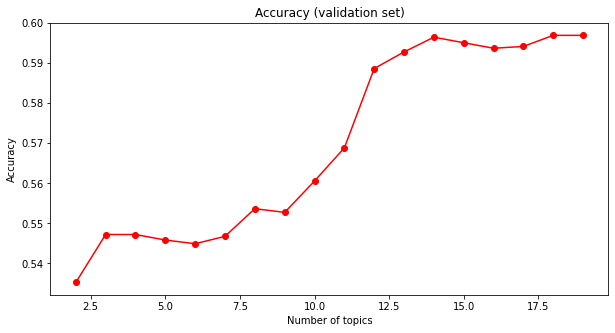

In [76]:
import matplotlib.pyplot as plt

def plot_accuracies(errors, x):
  
  fig, axes = plt.subplots(1,1, figsize=(10,5), sharex=False, sharey=False)
  ax1=axes
  

  
  ax1.plot(x,errors, color='red', marker="o")
  ax1.set_title('Accuracy (validation set)')
  ax1.set_xlabel('Number of topics')
  ax1.set_ylabel('Accuracy')

plot_accuracies(accuracies, list(c))

#### 3 genres
So the number of topics does not really make a difference, Around 8 or 10 topics good enough

#### 2 genres
4 topics is clearly the max that we need for this purpose

#### 3 genres 2 (Metal/Rock/HipHop)
9 topic has the highest accuracy

#### 4 genres
12 topics

## Creating BERT tokens

In [77]:
import transformers
# what we're used to: BERT
from transformers import BertTokenizer, BertModel 

MODEL_NAME = 'bert-base-uncased'
# Load pre-trained model
model = BertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


In [78]:
# Test script
# %%time
# # one dimension of difference: speed
# samp_lyrics = x_train['Lyric'].iloc[:100]
# tokens = tokenizer.batch_encode_plus(x_train['Lyric'].iloc[:5],
#   pad_to_max_length=True, return_tensors="pt", 
#   max_length=512) # BERT expects sequences of 512 tokens
# outputs = model(**tokens)

In [79]:

# # start: 
# save_pickle('bert_lyrics_sm.pkl', outputs)
# save_pickle('all_data.pkl', (x_test, x_val, x_test, y_train, y_val, y_test))

# import gzip
# pickle.dump(outputs, gzip.open(f'{path}lyrics_bert_vectors.pkl.gz', 'wb'))

In [80]:
# outputs[0].shape # 5x512x768

In [81]:
# set the whole model to GPU
model.to(device)

# here we're doing small batches to the model on GPU, we'll load the product of this process later
# The model itself takes up a LOT of memory, so we're passing very small batches
# note here: You may run out of RAM if you try and run this along with all the above.

def generate_BERT_tokens(data, filename):
  
  st = 0
  batch_size = 5
  batches = list(range(batch_size, len(data), batch_size))+[len(data)]
  # print(batches)
  doc_rep_collector = []
  for b in batches:
      tokens = tokenizer.batch_encode_plus(
          data["Lyric"][st:b],
          pad_to_max_length=True, 
          return_tensors="pt",
          max_length=512,
          truncation=True)
      st = b
      tokens.to(device)
      outputs = model(**tokens)
      # taking the representation of the 'CLS' token (doc-level embedding)
      o = outputs[0][:,0].cpu().detach().numpy()
      doc_rep_collector.append(o)

  # stack into array
  doc_rep_collector = np.concatenate(doc_rep_collector)
  
  # to minimize size, can store as 16-bit float
  doc_rep_collector = doc_rep_collector.astype('float16')

  # additionally, will store as gzip (pandas can handle this)
  pickle.dump(doc_rep_collector, gzip.open(f'{path}{filename}', 'wb'))

In [82]:
%%time
if COLAB:
  generate_BERT_tokens(x_train, 'lyrics_bert_vectors_train.pkl.gz')
  

CPU times: user 1min 42s, sys: 1min 4s, total: 2min 47s
Wall time: 2min 47s


Laptop:
```
Wall time ~ 2min 40s for 100 records
```

Colab:
```
CPU times: user 1min 55s, sys: 1min 14s, total: 3min 10s
Wall time: 3min 10s
```

In [83]:
%%time
if COLAB:
  generate_BERT_tokens(x_val, 'lyrics_bert_vectors_val.pkl.gz')




CPU times: user 46.7 s, sys: 29.9 s, total: 1min 16s
Wall time: 1min 16s


Colab:
```
CPU times: user 52.5 s, sys: 34.1 s, total: 1min 26s
Wall time: 1min 26s,
```

In [84]:
%%time
if COLAB:
  generate_BERT_tokens(x_test, 'lyrics_bert_vectors_test.pkl.gz')

CPU times: user 1min 4s, sys: 42.1 s, total: 1min 46s
Wall time: 1min 47s


Colab
```
CPU times: user 1min 11s, sys: 46.8 s, total: 1min 58s
Wall time: 1min 58s
```

In [85]:
# load the BERT
lyrics_bert_vectors_train = pd.read_pickle(f'{path}lyrics_bert_vectors_train.pkl.gz')
lyrics_bert_vectors_val = pd.read_pickle(f'{path}lyrics_bert_vectors_val.pkl.gz')
lyrics_bert_vectors_test = pd.read_pickle(f'{path}lyrics_bert_vectors_test.pkl.gz')

In [86]:
# BERT prediction
train_SVC(lyrics_bert_vectors_train, y_train["Genre"], lyrics_bert_vectors_val, y_val["Genre"])

Accuracy: 0.7


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.696453247351451

# Part 2: Notebook 05 - Model and Prediction - SMALL COLAB Version

Model selection and tuning of the model

## Data files needed to run this notebook:
- X_train.pkl.gz
- X_test.pkl.gz
- y_test_.pkl.gz
- y_train.pkl.gz

all the results from notebook 04

## Settings:
- set `COLAB = True` if you run this on Colab. Data can be placed in the root directory

In [87]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
from numpy import log, mean, matmul


# required = {'spacy', 'scikit-learn', 'numpy', 
#             'pandas', 'torch', 'matplotlib',
#             'transformers', 'allennlp==0.9.0'}
# installed = {pkg.key for pkg in pkg_resources.working_set}
# missing = required - installed

# if missing:
#     python = sys.executable
#     subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import spacy
import numpy as np
import pandas as pd

# SciKit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# Spacy
from spacy.lang.en import English
en = English()

# !python -m spacy download en_core_web_md # includes GloVe Vectors
# !python -m spacy download en_core_web_sm
# !python -m spacy download en

# import en_core_web_sm
# import en_core_web_md


# PyTorch
import torch
# import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

# File managment
import os
from os import listdir
from pathlib import Path
import pickle
import gzip

In [88]:
# LOAD_DATA = False # read save data or regenerate data
# SAVE_DATA = False # overwrite generated data? 

# COLAB = True

In [89]:
# if COLAB:
#   # Google Colab
#   path = "./"
#   device = torch.device("cuda:0") # use GPU, change 
# else:
#   # Laptop
#   path = "./data/"
#   device = torch.device("cpu")
# #   !pip install ipywidgets
# #   !jupyter nbextension enable --py widgetsnbextension

In [90]:
# df_total = pd.read_pickle(f'{path}df_total_cleaned.pkl.gz')

X_train = pd.read_pickle(f'{path}X_train.pkl.gz')
y_train = pd.read_pickle(f'{path}y_train.pkl.gz')



In [91]:
text_cols = ["SName", "Lyric", "Artist"]
genres = list(pd.DataFrame(y_train)["Genre"].unique())

In [92]:
y_train

19167     Hip Hop
88089     Hip Hop
41285     Hip Hop
12664        Rock
52249     Hip Hop
           ...   
127879      Metal
80491        Rock
66750        Rock
133337      Metal
99994        Rock
Name: Genre, Length: 8400, dtype: object

In [93]:
test_size = 0.3
tmp = X_train.drop(text_cols,axis=1)
tmp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
19167,0.001492,-0.273682,0.150513,-0.246460,-0.050476,-0.072327,0.447510,0.275391,-0.255859,-0.431396,-0.081238,0.441895,-0.335938,-0.404785,-0.085999,0.527344,0.418213,0.027115,0.174438,-0.009880,-0.281738,-0.009178,0.066895,-0.239380,0.115173,0.156494,-0.669434,-0.170898,-0.112000,-0.060516,-0.484375,0.589844,0.041840,-0.434814,0.671387,0.115479,0.577148,-0.383057,-0.043182,-0.361084,...,-0.031464,-0.180786,0.007504,0.675781,0.023895,-0.534668,0.239746,-0.245850,0.010201,-0.446045,-0.302002,0.046783,-0.059479,-0.473389,-0.381592,1.175781,-0.134888,0.250488,-0.156982,-0.307861,-0.015541,-0.601074,-0.520020,0.265625,-5.578125,-0.268555,0.041260,-0.620117,-0.388916,0.096130,0.408203,-1.025391,-0.107178,-0.021561,0.352051,0.488770,-0.528320,-0.062469,0.002211,0.423340
88089,0.037231,0.150635,0.496826,0.196777,-0.322998,-0.077271,0.991211,0.152954,-0.482910,-0.359619,-0.137451,-0.024475,-0.678223,0.299316,0.220581,0.517090,0.036346,-0.056274,0.417236,0.355957,0.022278,-0.016312,0.398193,-0.081360,0.247314,-0.013885,-0.188965,-0.506348,-0.417236,0.346924,-0.166260,0.611816,-0.352539,-0.379639,-0.019470,-0.540527,0.359131,-0.183228,0.541504,-0.265137,...,-0.192505,-0.093079,-0.156372,0.909668,-0.449951,-0.079224,-0.250977,0.151123,-0.406006,-0.051727,-0.394043,0.213257,-0.023788,-0.221436,-0.068909,0.601562,-0.221191,0.357666,-0.402588,-0.054291,-0.025070,0.028488,-0.106384,0.453857,-4.980469,-0.636230,-0.126953,-0.451660,-0.179565,-0.520508,0.160156,-0.338623,0.003363,0.037933,0.612305,0.417236,-0.303955,-0.520508,0.493164,0.340820
41285,-0.041718,-0.246704,-0.162720,0.137085,-0.043579,-0.229004,0.499023,0.824219,0.036102,-0.441650,-0.287842,0.302002,-0.357422,-0.162109,0.616211,0.209351,-0.001165,0.073853,0.220581,0.062866,-0.047211,-0.130005,0.078247,-0.201782,-0.113220,-0.219360,-0.531250,-0.626953,0.180786,-0.088928,-0.255615,0.347656,0.206543,-0.015564,0.802246,0.007030,-0.061890,-0.476074,0.155151,0.197388,...,-0.265869,-0.166504,-0.100159,0.726074,-0.086182,0.092102,0.175537,-0.158691,0.028442,-0.524902,0.104309,0.338623,-0.042816,-0.288574,-0.396729,0.647461,0.274902,0.750488,-0.162964,0.336182,-0.124146,-0.708496,-0.353516,-0.080688,-5.890625,-0.016678,-0.112183,-0.858398,-0.758789,-0.257568,0.738770,-0.558594,-0.090698,-0.180176,0.313232,0.296143,-0.604004,-0.382080,0.578613,0.207520
12664,-0.325684,0.143311,-0.226196,-0.002642,-0.749023,0.127930,0.955078,0.399902,-0.119263,-0.517090,-0.204956,-0.348389,-0.453613,0.671875,0.931641,0.144043,0.054565,0.833496,0.304688,0.268066,-0.174561,-0.203003,0.282715,-0.172363,0.033081,-0.107117,-0.324707,-0.375488,-0.130981,-0.239624,-0.355713,0.708984,-0.438232,-0.604492,0.538086,-0.252441,0.388916,0.180908,0.363770,-0.345215,...,-0.143433,-0.485840,-0.148071,0.555664,-0.346436,-0.685059,0.348145,0.134766,-0.212891,-0.307129,-0.403809,0.779297,0.333008,-0.410889,-0.045044,0.955078,0.443115,0.821777,-0.252441,-0.125244,0.316895,-0.520996,0.196411,0.341064,-5.328125,-0.554688,-0.337158,-0.794922,0.208862,0.528320,0.154175,-0.275879,-0.046143,-0.173706,0.242676,0.716797,-0.252197,-0.583008,0.321533,0.259033
52249,0.061066,0.076416,0.814453,-0.269531,-0.344238,0.150757,0.812500,0.367432,-0.025284,-0.302490,-0.051453,0.136597,-0.394287,-0.042206,0.085449,0.557129,0.353027,-0.274414,0.265625,0.221313,-0.042145,-0.318848,0.266602,-0.055389,0.083191,0.169922,-0.253662,-0.134888,0.048798,0.558105,-0.302979,0.624512,-0.003006,-0.409180,0.468506,-0.600098,0.716309,-0.145508,0.448242,-0.265137,...,-0.317871,0.006969,-0.120300,0.863770,-0.075195,-0.203613,-0.382568,-0.025375,-0.026672,-0.160645,-0.152100,0.079102,0.102905,-0.731934,-0.254395,1.055664,-0.647461,0.386719,-0.542969,0.124084,0.029068,-0.443359,-0.394043,0.487061,

In [94]:
X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(tmp, y_train, test_size=test_size, random_state=0, shuffle = True, stratify = y_train)

In [95]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

def train_SVC(x,y,x_val, y_val):
  model = LinearSVC(max_iter=2000)
  model.fit(x, y)
  val_preds = model.predict(x_val)
  acc = accuracy_score(y_val, val_preds)
  print(f"Accuracy: {round(acc,2)}")
  return (acc, model, val_preds)

In [96]:
(acc, model, predictions) = train_SVC(X_train_set, y_train_set, X_val_set, y_val_set)

# running rock,hiphop, metal: -> 92%
# running pop,hiphop, metal: -> 85%
# running 4 genres -> 75%
# running pop, rock, hiphop _> 0.67

Accuracy: 0.92


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [97]:
# confusiont matrix
from sklearn.metrics import confusion_matrix

In [98]:
def print_confustion_matrix(model, y_val_set, predictions):
  cm = confusion_matrix(y_val_set, predictions)
  df = pd.DataFrame(cm, columns = model.classes_, index= model.classes_)
  print(df)
  
  
  

In [99]:
print_confustion_matrix(model, y_val_set, predictions)
  

         Hip Hop  Metal  Rock
Hip Hop      747      0    93
Metal          0    840     0
Rock          99      4   737


In [100]:
def wrong_classifications(X_train, y, predictions, genres):
  print("Truth - predicted")
  predictions_df = pd.DataFrame(predictions, columns = ["Genre_Predicted"])
  truth_df = pd.DataFrame(y)
  truth_df.columns = ["Genre_Truth"]
  combined_df = pd.concat([truth_df.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)
  for i in genres:
    for j in genres:
      if i!=j:
        idx = combined_df.query(f"Genre_Truth =='{i}' != Genre_Predicted=='{j}'").index
        if len(idx)>0:
          print("------------------------------")
          print(f"{i} - {j}")
          print("------------------------------")
          print(X_train.iloc[idx]["Lyric"])
 

In [101]:
 
wrong_classifications(X_train, y_val_set,predictions  , genres)

Truth - predicted
------------------------------
Hip Hop - Rock
------------------------------
6121      previously on ashanti "always there when you c...
19946     Before I get started. polo this beat is retart...
126819    Patrz   w siebie i widz   coraz mniej Powoli p...
33512     Fatjoe: TS. Thalía: Hey baby. Fatjoe: Yeah. Th...
126051    I felt the ground start to shake  Oh God  oh G...
                                ...                        
30991     Its 2002, everything was totally new. We were ...
21676     It's time to make a difference. I know he's ba...
112568    Cross me once more fool me cross me twice and ...
6192       why dont you take me tonight. take me away wh...
66616     she said that she'd take it off right here. ta...
Name: Lyric, Length: 93, dtype: object
------------------------------
Rock - Hip Hop
------------------------------
26589     I didn't hear you leave,. I wonder how am I st...
59383     Your breath is sweet. Your eyes are like two j...
49296    

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_val_set, predictions, target_names=genres))

              precision    recall  f1-score   support

     Hip Hop       0.88      0.89      0.89       840
        Rock       1.00      1.00      1.00       840
       Metal       0.89      0.88      0.88       840

    accuracy                           0.92      2520
   macro avg       0.92      0.92      0.92      2520
weighted avg       0.92      0.92      0.92      2520



In [103]:
# Try different kernels and values of hyper parameters to see if we can improve the score
# this method uses cross validation so we could use the whole data set (we do ot so we can use the val to get the test score of the fitted model, with the parameters. )

In [104]:
%%time
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_set, y_train_set)


CPU times: user 3min 43s, sys: 90.8 ms, total: 3min 43s
Wall time: 3min 43s


In [105]:
print(clf.best_params_)

{'C': 10, 'kernel': 'poly'}


In [106]:
list(zip(clf.cv_results_['params'], clf.cv_results_['mean_test_score']))

[({'C': 1, 'kernel': 'linear'}, 0.9285714285714285),
 ({'C': 1, 'kernel': 'rbf'}, 0.9396258503401361),
 ({'C': 1, 'kernel': 'poly'}, 0.9430272108843537),
 ({'C': 1, 'kernel': 'sigmoid'}, 0.9333333333333333),
 ({'C': 10, 'kernel': 'linear'}, 0.9171768707482993),
 ({'C': 10, 'kernel': 'rbf'}, 0.9430272108843537),
 ({'C': 10, 'kernel': 'poly'}, 0.94421768707483),
 ({'C': 10, 'kernel': 'sigmoid'}, 0.9047619047619048)]

In [107]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.873948,0.055515,0.899429,0.010507,1,linear,"{'C': 1, 'kernel': 'linear'}",0.933673,0.931973,0.928571,0.918367,0.930272,0.928571,0.005378,6
1,4.463384,0.035716,1.391153,0.012889,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.942177,0.941327,0.938776,0.926871,0.948980,0.939626,0.007215,4
2,4.138443,0.053898,1.292291,0.021583,1,poly,"{'C': 1, 'kernel': 'poly'}",0.943878,0.946429,0.942177,0.932823,0.949830,0.943027,0.005717,2
3,5.424395,0.051900,1.623484,0.014625,1,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",0.937925,0.931122,0.929422,0.924320,0.943878,0.933333,0.006837,5
4,4.432620,0.133599,0.828467,0.005759,10,linear,"{'C': 10, 'kernel': 'linear'}",0.914116,0.924320,0.925170,0.911565,0.910714,0.917177,0.006286,7
5,3.957435,0.062443,1.241372,0.019420,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.946429,0.948980,0.941327,0.930272,0.948129,0.943027,0.006908,2
6,3.842974,0.084792,1.202314,0.029794,10,poly,"{'C': 10, 'kernel': 'poly'}",0.948980,0.950680,0.939626,0.933673,0.948129,0.944218,0.006512,1
7,4.074712,0.284715,0.865831,0.005947,10,sigmoid,"{'C': 10, 'kernel': 'sigmoid'}",0.907313,0.906463,0.907313,0.905612,0.897109,0.904762,0.003878,8


Sigmoid is doing the worst
- Linear betwee 0.91 and 0.92
- rbf: 0.93, 0.94
- Poly: 0.94 (may be overfitting) but ar the best scores
- Sigmoid, 0.93, 0.90

## SVC: 
Choose the best kernel and optimize that one.
We have vectors in a many dimensional space, so we don't really know what is the valid choice. We just try to optimize the problem, not trying to explain what happens under the hood. 

## Radial Kernel - RBF

In [108]:
%%time
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':(['rbf']), 'C':[0.5, 1, 5, 10,20]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_set, y_train_set)


CPU times: user 2min 26s, sys: 56.1 ms, total: 2min 26s
Wall time: 2min 26s


In [109]:
print(clf.best_params_)

{'C': 5, 'kernel': 'rbf'}


In [110]:
list(zip(clf.cv_results_['params'], clf.cv_results_['mean_test_score']))

[({'C': 0.5, 'kernel': 'rbf'}, 0.936734693877551),
 ({'C': 1, 'kernel': 'rbf'}, 0.9396258503401361),
 ({'C': 5, 'kernel': 'rbf'}, 0.9438775510204082),
 ({'C': 10, 'kernel': 'rbf'}, 0.9430272108843537),
 ({'C': 20, 'kernel': 'rbf'}, 0.9431972789115648)]

- For 3 genres: Best value for RBF: {'C': 5, 'kernel': 'rbf'} 0.94
- For 4 genres: ({'C': 5, 'kernel': 'rbf'}, 0.7687074829931972),

## Polynomial Kernel
Optimize _C_ value and degrees of the polynomial approximation.

In [111]:
%%time
parameters = {'kernel':(['poly']), 'C':[0.5, 1, 5, 10,20], 'degree':[2,3,4]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_set, y_train_set)

CPU times: user 6min 48s, sys: 180 ms, total: 6min 48s
Wall time: 6min 48s


In [112]:
print(clf.best_params_)

{'C': 5, 'degree': 4, 'kernel': 'poly'}


In [113]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.755677,0.058995,1.454950,0.019303,0.5,2,poly,"{'C': 0.5, 'degree': 2, 'kernel': 'poly'}",0.941327,0.937925,0.937075,0.926020,0.948129,0.938095,0.007183,15
1,4.593794,0.034489,1.417227,0.008735,0.5,3,poly,"{'C': 0.5, 'degree': 3, 'kernel': 'poly'}",0.938776,0.940476,0.937925,0.926020,0.948129,0.938265,0.007106,14
2,4.675459,0.051954,1.431154,0.011824,0.5,4,poly,"{'C': 0.5, 'degree': 4, 'kernel': 'poly'}",0.936224,0.940476,0.937925,0.929422,0.950680,0.938946,0.006917,13
3,4.112772,0.059912,1.287326,0.017280,1,2,poly,"{'C': 1, 'degree': 2, 'kernel': 'poly'}",0.938776,0.944728,0.940476,0.927721,0.948980,0.940136,0.007147,11
4,4.118490,0.062936,1.288353,0.021444,1,3,poly,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",0.943878,0.946429,0.942177,0.932823,0.949830,0.943027,0.005717,6
5,4.269174,0.078279,1.318931,0.022844,1,4,poly,"{'C': 1, 'degree': 4, 'kernel': 'poly'}",0.943878,0.948129,0.943878,0.934524,0.953231,0.944728,0.006155,2
6,3.582490,0.017219,1.130658,0.010276,5,2,poly,"{'C': 5, 'degree': 2, 'kernel': 'poly'}",0.943878,0.947279,0.940476,0.930272,0.947279,0.941837,0.006309,8
7,3.777670,0.058286,1.185856,0.021472,5,3,poly,"{'C': 5, 'degree': 3, 'kernel': 'poly'}",0.948129,0.945578,0.942177,0.932823,0.949830,0.943707,0.006022,4
8,4.049538,0.060477,1.265976,0.022827,5,4,poly,"{'C': 5, 'degree': 4, 'kernel': 'poly'}",0.949830,0.948129,0.943027,0.936224,0.948980,0.945238,0.005091,1
9,3.599700,0.038878,1.122156,0.021382,10,2,poly,"{'C': 10, 'degree': 2, 'kernel': 'poly'}",0.949830,0.948980,0.940476,0.931973,0.942177,0.942687,0.006489,7


A lot of calculations, but the differences are very small. So the poly nomial with 2 degrees and C=5 will do just fine. Better to have less degrees, than more to prevent overfitting.

For 4 categories:
- {'C': 1, 'degree': 3, 'kernel': 'poly'}


# Stochastic gradient descent

In [114]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train_num = le.fit_transform(y_train_set)
# y_val_num = le.transform(y_val_set)


In [115]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))

clf.fit(X_train_set, y_train_set)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [116]:
predictions = clf.predict(X_val_set)

In [117]:
accuracy_score(y_val_set, predictions)

0.928968253968254

The performance here is worse.

## KNeigbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_set, y_train_set)

predictions = neigh.predict(X_val_set)
accuracy_score(y_val_set, predictions)
# print(neigh.predict_proba([[0.9]]))

So this one in less accurate. But let's see if we can improve the results. 

In [ ]:
# Tuning of the results

In [ ]:
%%time 
parameters = {'n_neighbors':[3,4,5,6,7]}
clf = GridSearchCV(neigh, parameters)
clf.fit(X_train_set, y_train_set)

In [ ]:
print(clf.best_params_)

In [ ]:
pd.DataFrame(clf.cv_results_)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=clf.best_params_["n_neighbors"])
neigh.fit(X_train_set, y_train_set)

predictions = neigh.predict(X_val_set)
accuracy_score(y_val_set, predictions)
# print(neigh.predict_proba([[0.9]]))


A little improvement over the 3 neighbors, but not so much

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_set, y_train_set)

predictions = clf.predict(X_val_set)
accuracy_score(y_val_set, predictions)

So this option also performs less. The assumption for Guassian distribution is probably als not valid

## Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(random_state=1, hidden_layer_sizes=(500,500), max_iter=500).fit(X_train_set, y_train_set)

predictions = clf.predict(X_val_set)
accuracy_score(y_val_set, predictions)

In [ ]:
clf.predict_proba(X_val_set[0:10])

In [ ]:
predictions = clf.predict(X_val_set)
accuracy_score(y_val_set, predictions)

In [ ]:
clf.score(X_val_set, y_val_set)

In [ ]:
# All the results are in the range of 92%-94%
print_confustion_matrix(clf, y_val_set, predictions)

- different classifier have marginal effect
- There must be something in the dataset in the Metal, it's classified correctly almost too much compared to the other genres. But is not clear what its. 
    - Some different languages. 

Best model: RBC for SVC
({'C': 5, 'kernel': 'rbf'}, 0.7687074829931972) for 4 category classifier.

Neural net: 500x500 hidden layers.
 - Pop and rock are the genres most closely related.

## Result of the chosen model

- For the front end we'll set up the system with SVC, Radial kernel, with C=5
- We fit the model on the complete training set
- We evaluate on the test set

In [118]:
X_train.head()

,SName,Lyric,Artist,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
19167,Back To Sleep,"I know it's late, I know it's late. And baby I...",Chris Brown,0.001492,-0.273682,0.150513,-0.246460,-0.050476,-0.072327,0.447510,0.275391,-0.255859,-0.431396,-0.081238,0.441895,-0.335938,-0.404785,-0.085999,0.527344,0.418213,0.027115,0.174438,-0.009880,-0.281738,-0.009178,0.066895,-0.239380,0.115173,0.156494,-0.669434,-0.170898,-0.112000,-0.060516,-0.484375,0.589844,0.041840,-0.434814,0.671387,0.115479,0.577148,...,-0.031464,-0.180786,0.007504,0.675781,0.023895,-0.534668,0.239746,-0.245850,0.010201,-0.446045,-0.302002,0.046783,-0.059479,-0.473389,-0.381592,1.175781,-0.134888,0.250488,-0.156982,-0.307861,-0.015541,-0.601074,-0.520020,0.265625,-5.578125,-0.268555,0.041260,-0.620117,-0.388916,0.096130,0.408203,-1.025391,-0.107178,-0.021561,0.352051,0.488770,-0.528320,-0.062469,0.002211,0.423340
88089,The Best,The Best. Soulja Boy. Soulja! Soulja! Soulja! ...,Soulja Boy,0.037231,0.150635,0.496826,0.196777,-0.322998,-0.077271,0.991211,0.152954,-0.482910,-0.359619,-0.137451,-0.024475,-0.678223,0.299316,0.220581,0.517090,0.036346,-0.056274,0.417236,0.355957,0.022278,-0.016312,0.398193,-0.081360,0.247314,-0.013885,-0.188965,-0.506348,-0.417236,0.346924,-0.166260,0.611816,-0.352539,-0.379639,-0.019470,-0.540527,0.359131,...,-0.192505,-0.093079,-0.156372,0.909668,-0.449951,-0.079224,-0.250977,0.151123,-0.406006,-0.051727,-0.394043,0.213257,-0.023788,-0.221436,-0.068909,0.601562,-0.221191,0.357666,-0.402588,-0.054291,-0.025070,0.028488,-0.106384,0.453857,-4.980469,-0.636230,-0.126953,-0.451660,-0.179565,-0.520508,0.160156,-0.338623,0.003363,0.037933,0.612305,0.417236,-0.303955,-0.520508,0.493164,0.340820
41285,Just Askin',"Wassup, in your world?. And are you still cool...",Iggy Azalea,-0.041718,-0.246704,-0.162720,0.137085,-0.043579,-0.229004,0.499023,0.824219,0.036102,-0.441650,-0.287842,0.302002,-0.357422,-0.162109,0.616211,0.209351,-0.001165,0.073853,0.220581,0.062866,-0.047211,-0.130005,0.078247,-0.201782,-0.113220,-0.219360,-0.531250,-0.626953,0.180786,-0.088928,-0.255615,0.347656,0.206543,-0.015564,0.802246,0.007030,-0.061890,...,-0.265869,-0.166504,-0.100159,0.726074,-0.086182,0.092102,0.175537,-0.158691,0.028442,-0.524902,0.104309,0.338623,-0.042816,-0.288574,-0.396729,0.647461,0.274902,0.750488,-0.162964,0.336182,-0.124146,-0.708496,-0.353516,-0.080688,-5.890625,-0.016678,-0.112183,-0.858398,-0.758789,-0.257568,0.738770,-0.558594,-0.090698,-0.180176,0.313232,0.296143,-0.604004,-0.382080,0.578613,0.207520
12664,You Wear A Crown But You're No King,You'll never stop 'til you get what you want. ...,Blessthefall,-0.325684,0.143311,-0.226196,-0.002642,-0.749023,0.127930,0.955078,0.399902,-0.119263,-0.517090,-0.204956,-0.348389,-0.453613,0.671875,0.931641,0.144043,0.054565,0.833496,0.304688,0.268066,-0.174561,-0.203003,0.282715,-0.172363,0.033081,-0.107117,-0.324707,-0.375488,-0.130981,-0.239624,-0.355713,0.708984,-0.438232,-0.604492,0.538086,-0.252441,0.388916,...,-0.143433,-0.485840,-0.148071,0.555664,-0.346436,-0.685059,0.348145,0.134766,-0.212891,-0.307129,-0.403809,0.779297,0.333008,-0.410889,-0.045044,0.955078,0.443115,0.821777,-0.252441,-0.125244,0.316895,-0.520996,0.196411,0.341064,-5.328125,-0.554688,-0.337158,-0.794922,0.208862,0.528320,0.154175,-0.275879,-0.046143,-0.173706,0.242676,0.716797,-0.252197,-0.583008,0.321533,0.259033
52249,Kevin Gates,Workout. Tell. Workout. Tell. Gates. Gates. Ga...,Kevin Gates,0.061066,0.076416,0.814453,-0.269531,-0.344238,0.150757,0.812500,0.367432,-0.025284,-0.302490,-0.051453,0.136597,-0.394287,-0.042206,0.085449,0.557129,0.353027,-0.274414,0.265625,0.221313,-0.042145,-0.318848,0.266602,-0.055389,0.083191,0.169922,-0.253662,-0.134888,0.048798,0.558105,-0.302979,0.624512,-0.003006,-0.409180,

In [119]:
y_train

19167     Hip Hop
88089     Hip Hop
41285     Hip Hop
12664        Rock
52249     Hip Hop
           ...   
127879      Metal
80491        Rock
66750        Rock
133337      Metal
99994        Rock
Name: Genre, Length: 8400, dtype: object

In [120]:
X_train_final = X_train.drop(text_cols, axis=1)
X_train_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
19167,0.001492,-0.273682,0.150513,-0.246460,-0.050476,-0.072327,0.447510,0.275391,-0.255859,-0.431396,-0.081238,0.441895,-0.335938,-0.404785,-0.085999,0.527344,0.418213,0.027115,0.174438,-0.009880,-0.281738,-0.009178,0.066895,-0.239380,0.115173,0.156494,-0.669434,-0.170898,-0.112000,-0.060516,-0.484375,0.589844,0.041840,-0.434814,0.671387,0.115479,0.577148,-0.383057,-0.043182,-0.361084,...,-0.031464,-0.180786,0.007504,0.675781,0.023895,-0.534668,0.239746,-0.245850,0.010201,-0.446045,-0.302002,0.046783,-0.059479,-0.473389,-0.381592,1.175781,-0.134888,0.250488,-0.156982,-0.307861,-0.015541,-0.601074,-0.520020,0.265625,-5.578125,-0.268555,0.041260,-0.620117,-0.388916,0.096130,0.408203,-1.025391,-0.107178,-0.021561,0.352051,0.488770,-0.528320,-0.062469,0.002211,0.423340
88089,0.037231,0.150635,0.496826,0.196777,-0.322998,-0.077271,0.991211,0.152954,-0.482910,-0.359619,-0.137451,-0.024475,-0.678223,0.299316,0.220581,0.517090,0.036346,-0.056274,0.417236,0.355957,0.022278,-0.016312,0.398193,-0.081360,0.247314,-0.013885,-0.188965,-0.506348,-0.417236,0.346924,-0.166260,0.611816,-0.352539,-0.379639,-0.019470,-0.540527,0.359131,-0.183228,0.541504,-0.265137,...,-0.192505,-0.093079,-0.156372,0.909668,-0.449951,-0.079224,-0.250977,0.151123,-0.406006,-0.051727,-0.394043,0.213257,-0.023788,-0.221436,-0.068909,0.601562,-0.221191,0.357666,-0.402588,-0.054291,-0.025070,0.028488,-0.106384,0.453857,-4.980469,-0.636230,-0.126953,-0.451660,-0.179565,-0.520508,0.160156,-0.338623,0.003363,0.037933,0.612305,0.417236,-0.303955,-0.520508,0.493164,0.340820
41285,-0.041718,-0.246704,-0.162720,0.137085,-0.043579,-0.229004,0.499023,0.824219,0.036102,-0.441650,-0.287842,0.302002,-0.357422,-0.162109,0.616211,0.209351,-0.001165,0.073853,0.220581,0.062866,-0.047211,-0.130005,0.078247,-0.201782,-0.113220,-0.219360,-0.531250,-0.626953,0.180786,-0.088928,-0.255615,0.347656,0.206543,-0.015564,0.802246,0.007030,-0.061890,-0.476074,0.155151,0.197388,...,-0.265869,-0.166504,-0.100159,0.726074,-0.086182,0.092102,0.175537,-0.158691,0.028442,-0.524902,0.104309,0.338623,-0.042816,-0.288574,-0.396729,0.647461,0.274902,0.750488,-0.162964,0.336182,-0.124146,-0.708496,-0.353516,-0.080688,-5.890625,-0.016678,-0.112183,-0.858398,-0.758789,-0.257568,0.738770,-0.558594,-0.090698,-0.180176,0.313232,0.296143,-0.604004,-0.382080,0.578613,0.207520
12664,-0.325684,0.143311,-0.226196,-0.002642,-0.749023,0.127930,0.955078,0.399902,-0.119263,-0.517090,-0.204956,-0.348389,-0.453613,0.671875,0.931641,0.144043,0.054565,0.833496,0.304688,0.268066,-0.174561,-0.203003,0.282715,-0.172363,0.033081,-0.107117,-0.324707,-0.375488,-0.130981,-0.239624,-0.355713,0.708984,-0.438232,-0.604492,0.538086,-0.252441,0.388916,0.180908,0.363770,-0.345215,...,-0.143433,-0.485840,-0.148071,0.555664,-0.346436,-0.685059,0.348145,0.134766,-0.212891,-0.307129,-0.403809,0.779297,0.333008,-0.410889,-0.045044,0.955078,0.443115,0.821777,-0.252441,-0.125244,0.316895,-0.520996,0.196411,0.341064,-5.328125,-0.554688,-0.337158,-0.794922,0.208862,0.528320,0.154175,-0.275879,-0.046143,-0.173706,0.242676,0.716797,-0.252197,-0.583008,0.321533,0.259033
52249,0.061066,0.076416,0.814453,-0.269531,-0.344238,0.150757,0.812500,0.367432,-0.025284,-0.302490,-0.051453,0.136597,-0.394287,-0.042206,0.085449,0.557129,0.353027,-0.274414,0.265625,0.221313,-0.042145,-0.318848,0.266602,-0.055389,0.083191,0.169922,-0.253662,-0.134888,0.048798,0.558105,-0.302979,0.624512,-0.003006,-0.409180,0.468506,-0.600098,0.716309,-0.145508,0.448242,-0.265137,...,-0.317871,0.006969,-0.120300,0.863770,-0.075195,-0.203613,-0.382568,-0.025375,-0.026672,-0.160645,-0.152100,0.079102,0.102905,-0.731934,-0.254395,1.055664,-0.647461,0.386719,-0.542969,0.124084,0.029068,-0.443359,-0.394043,0.487061,

In [121]:
model = SVC(max_iter=4000, kernel='rbf', C=5)

In [122]:
model.fit(X_train_final, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=4000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [123]:
# Do not write for this small notebook
# pickle.dump(model, gzip.open(f'{path}{"final_lyrics_model.pkl.gz"}', 'wb'))

In [124]:
# load the test set
X_test = pd.read_pickle(f'{path}X_test.pkl.gz')
y_test = pd.read_pickle(f'{path}y_test.pkl.gz')

print(X_test.shape, y_test.shape)

(3600, 771) (3600,)


In [125]:
X_test_final = X_test.drop(text_cols, axis=1)
X_test_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
89956,-0.244995,-0.127075,0.097412,-0.187256,-0.259521,-0.194092,0.568359,0.562012,-0.143677,-0.538086,-0.088745,0.024734,-0.390625,-0.017960,0.118286,0.623535,0.367432,0.048218,0.535645,0.066223,-0.355225,0.094849,0.306641,-0.430664,-0.182251,0.109436,-0.612305,-0.441895,-0.364258,-0.038361,-0.676270,0.712891,-0.276611,-0.604492,0.422852,0.084900,0.187744,-0.110535,0.458008,-0.352051,...,-0.166016,-0.221558,-0.136230,0.709473,-0.186157,-0.458496,0.064331,-0.041840,-0.337891,-0.149536,-0.403076,0.602539,0.272461,-0.464355,0.050476,1.202148,0.396729,0.179443,-0.330078,-0.309570,-0.083679,-0.282959,-0.058685,0.698242,-4.859375,-0.615723,0.002083,-0.978516,-0.359619,0.036774,0.078186,-0.501465,-0.123047,-0.450195,0.400635,0.800293,-0.675293,0.069397,0.398193,0.586426
33634,-0.034454,-0.149658,0.664062,-0.213867,-0.482178,-0.253418,0.167114,0.550293,-0.196533,-0.573242,0.078186,-0.334961,-0.467529,-0.104736,0.178833,0.468750,0.051727,0.114929,0.150391,0.172241,-0.564941,-0.071411,0.366699,-0.521484,0.185425,0.025467,-0.388428,-0.493408,-0.468994,0.368408,-0.503906,0.593750,-0.203247,-0.558594,0.223633,-0.498291,0.469727,0.020569,0.582031,-0.208008,...,-0.717285,-0.250977,-0.345947,0.979492,0.085693,-0.156616,0.327393,0.002342,-0.353760,-0.480469,-0.537598,0.524414,-0.000020,-0.166382,-0.060822,0.953613,-0.458984,0.691895,-0.375977,-0.637695,0.044434,-0.244629,-0.293457,0.191528,-2.894531,-0.087585,-0.099121,-0.363770,-0.378418,0.028946,-0.312744,-0.751465,0.074219,-0.265137,-0.074219,0.669434,-0.548828,-0.318848,0.070435,0.294678
16861,0.141235,-0.208374,0.282715,-0.068359,-0.137085,-0.065552,0.525391,0.498535,-0.515137,-0.383545,0.304688,0.435791,-0.042938,0.311279,0.381348,0.785156,0.101868,-0.090088,0.291992,-0.042633,-0.469971,-0.387451,0.134399,-0.456787,-0.262207,-0.133301,-0.509766,-0.301758,-0.158203,0.171143,-0.478516,0.063721,-0.177734,-0.388916,0.388672,-0.337402,0.508301,0.145996,0.368652,-0.479980,...,-0.190186,-0.176025,0.038330,0.946777,-0.001671,0.091003,0.121887,-0.061127,-0.186035,-0.399170,-0.108215,0.005074,0.155151,-0.246460,-0.373291,0.813477,-0.269775,0.663574,-0.240601,-0.087708,0.295654,-0.014618,-0.708008,0.238647,-5.714844,-0.000671,0.015602,-0.653809,-0.694824,0.268555,0.154785,-0.604492,-0.254639,-0.252930,0.430420,0.540527,-0.599121,-0.480957,0.131470,0.092529
92314,0.345215,0.182495,0.065552,-0.339355,-0.525391,0.010788,0.584473,0.826660,-0.712402,-0.538574,0.109009,-0.178223,-0.596680,0.368896,0.419922,0.850586,-0.028397,0.223633,0.150757,0.229614,-0.493652,0.366455,0.123840,-0.393311,-0.048401,-0.068359,-0.155518,-0.427246,-0.048859,-0.028427,-0.234131,0.716309,-0.188354,-0.593750,0.766113,-0.404541,0.144043,-0.005875,0.049347,-0.344238,...,-0.024292,-0.551758,-0.195801,0.839844,-0.116760,-0.339600,0.472656,0.344971,-0.448730,-0.785156,-0.571289,0.630371,-0.128784,-0.294189,0.050598,0.420654,0.197998,0.874023,-0.305908,-0.744629,0.103455,-0.208618,0.011574,0.280518,-5.167969,0.191895,0.194702,-0.813477,-0.541016,0.362549,-0.051819,-0.761719,-0.501953,-0.466064,0.818848,0.695801,-0.710449,-0.107666,0.366455,0.580566
95289,-0.081360,0.009384,0.453613,-0.090454,-0.411133,0.203369,0.451904,0.871094,-0.225098,-1.244141,-0.017792,-0.135620,-0.295898,0.045471,0.503418,0.187866,0.167114,0.519043,0.439453,0.208984,-0.469971,0.458740,0.253174,-0.220825,-0.047302,-0.024475,-0.172729,-0.107727,-0.244385,0.267822,-0.441895,0.378906,-0.059235,-0.762207,0.257568,-0.119385,-0.118591,0.007145,0.069214,-0.089111,...,-0.675781,-0.275391,-0.181641,1.320312,-0.018234,-0.672852,0.470459,0.563965,-0.422363,-0.788086,-0.146118,0.209106,0.091858,-0.143799,0.082275,0.804199,-0.213135,0.225952,-0.654297,-0.669434,0.318359,0.105225,-0.309814,0.249146,-3.81

In [126]:
test_predictions = model.predict(X_test_final)

In [127]:
test_predictions.shape

(3600,)

In [128]:
y_test.shape

(3600,)

In [129]:
acc = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {round(acc,2)}")

Accuracy: 0.95


In [130]:
print_confustion_matrix(model, y_test, test_predictions)

         Hip Hop  Metal  Rock
Hip Hop     1063      0   137
Metal          0   1200     0
Rock          57      1  1142


In [131]:
print(classification_report(y_test, test_predictions, target_names=genres))

              precision    recall  f1-score   support

     Hip Hop       0.95      0.89      0.92      1200
        Rock       1.00      1.00      1.00      1200
       Metal       0.89      0.95      0.92      1200

    accuracy                           0.95      3600
   macro avg       0.95      0.95      0.95      3600
weighted avg       0.95      0.95      0.95      3600



# Part 3: Simplified Deployment 
Full version is available at the github repo:

https://github.com/erikbuunk/ismt-s117-final-project

Installation instructions:

https://github.com/erikbuunk/ismt-s117-final-project/blob/master/documentation/ISMT-S117-Final-Write-up-Erik-Buunk.pdf

YouTube movie with installation and demonstration!:
https://youtu.be/hlz_RryCHV4

In [132]:
# from fastapi import FastAPI
# from fastapi.staticfiles import StaticFiles
# !pip3 install -U scikit-learn scipy
from sklearn.svm import SVC


import pandas as pd
import pickle
import uuid
import torch
import re

import transformers

from transformers import BertTokenizer, BertModel

print("loading pretrained BERT feature model")
MODEL_NAME = 'bert-base-uncased'

# Load pre-trained model
bert_model = BertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# path = "./"
device = torch.device("cpu")
filename = path + "user_lyrics_data.csv"

print("Loading Trained Prediction Model")
prediction_model = model

# in the deployment this one is read form disk:
# prediction_model = pd.read_pickle(path + 'final_lyrics_model.pkl.gz')



def clean_single_lyric(text):
    x = text.strip()
    y = re.sub('\[.*?\]', '', x)
    z = re.sub('\(.*?\)', '', y)
    z1 = pd.DataFrame([z], columns=["Lyric"])
    return z1


def generate_single_BERT_token(text):
    tokens = tokenizer.batch_encode_plus(
        text["Lyric"],
        pad_to_max_length=True,
        return_tensors="pt",
        max_length=512,
        truncation=True)
    tokens.to(device)
    outputs = bert_model(**tokens)
    o = outputs[0][:, 0].cpu().detach().numpy()
    return o


def get_prediction(token):
    print("get prediction model")
    p = prediction_model.predict(token)
    print("Prediction: " + p)
    return p


def generate_id():
    uuidOne = uuid.uuid1()
    return uuidOne.hex


def write_prediction(cleaned_lyrics, token, prediction, id):
    df = pd.DataFrame.from_dict(
        {"id": [id], "Prediction": prediction, "Truth": '', "Lyric": cleaned_lyrics})
    df_token = pd.DataFrame(token)
    df_record = pd.concat([df, df_token], axis=1)

    try:
        with open(filename) as f:
            df_in = pd.read_csv(filename)
            if len(df_in[df_in["id"] == id]) == 0:
                df_in = df_in.append(df_record)
                df_in.to_csv(filename, index=False)
    except IOError:
        df_record.to_csv(filename, index=False)

    return


def update_prediction(id, new_value):
    df_in = pd.read_csv(filename)
    if len(df_in[df_in["id"] == id]) == 1:
        df_in.loc[df_in["id"] == id, ["Truth"]] = new_value
        df_in.to_csv(filename, index=False)


def predict(lyric):
    text = clean_single_lyric(lyric)
    token = generate_single_BERT_token(text)
    predicted_genre = get_prediction(token)
    id = generate_id()
    raw_text = list(text["Lyric"])
    write_prediction(raw_text, token, predicted_genre, id)
    return (id, predicted_genre)



loading pretrained BERT feature model
Loading Trained Prediction Model


In [133]:
# green day
lyricRock = "Amanda don't you know That I still walk around This foggy round about When I get back in town. I was a different man From five seconds ago Any you're a different woman, That's for certain, I don't know a thing about.  Is this some kind of love That only hate would understand? Amanda, I couldn't be your man.  Amanda don't you know I wasn't strong enough And in your wild mind I wasn't smart enough. I was a different kid From fifteen years ago And you're a different woman, That's for certain, I wanna know about.  Is this some kind of love That only hate would understand? Amanda, I couldn't be your man.  I'm not playin' with your mind... Unless you think I am. 'Cause you're crushing my heart Like a battering ram.  Is this some kind of love That only hate would understand? Amanda, I couldn't be your man."

In [134]:
predict(lyricRock)

get prediction model
['Prediction: Rock']


('88a52f56d8cd11eaab5b0242ac1c0002', array(['Rock'], dtype=object))

In [137]:
# Eminem 
lyricHipHop = "America, we love you How many people are proud to be citizens of this beautiful country of ours The stripes and the stars for the rights that men have died for to protect the women and men who have broke their necks for the freedom of speech the United States Government has sworn to uphold (Yo', I want everybody to listen to the words of this song) or so we're told...  I never would've dreamed in a million years I'd see So many motherfuckin' people who feel like me, Who share the same views and the same exact beliefs. It's like a fuckin' army marchin' in back of me.  So many lives I touched, so much anger aimed, In no particular direction, just sprays and sprays. And straight through your radio waves it plays and plays, 'Til it stays stuck in your head for days and days.  Who would've thought, standing in this mirror bleachin' my hair With some peroxide reaching for a T-shirt to wear, That I would catapult to the forefront of rap like this? How could I predict my words would have an impact like this?  I must've struck a chord, with somebody up in the office, Cause Congress keeps telling me I ain't causin' nothin' but problems, And now they're sayin' I'm in trouble with the government, I'm lovin' it, I shoveled shit all my life, And now I'm dumping it on  White America, I could be one of your kids, White America, little Eric looks just like this, White America, Erica loves my shit, I go to TRL, look how many hugs I get, White America, I could be one of your kids, White America, little Eric looks just like this, White America, Erica loves my shit, I go to TRL, look how many hugs I get  Look at these eyes, baby blue, baby just like yourself, If they were brown, Shady lose, Shady sits on the shelf, But Shady's cute, Shady knew, Shady's dimples would help Make ladies swoon, baby—ooh, baby!—look at my sales,  Let's do the math, if I was black, I would've sold half, I Ain't have to graduate from Lincoln High School to know that, But I could rap, so fuck school, I'm too cool to go back, Gimme the mic, show me where the fuckin' studio's at,  When I was underground, no one gave a fuck I was white, No labels wanted to sign me, almost gave up, I was like  'Fuck it! ' until I met Dre, the only one to look past, Gave me a chance, and I lit a fire up Under his ass,  Helped him get back to the top, every fan black that I got Was probably his in exchange for every white fan that he's got, Like damn, we just swapped, sittin' back lookin' at shit, wow, I'm like my skin is just starting to work to my benefit now, It's  White America, I could be one of your kids, White America, little Eric looks just like this, White America, Erica loves my shit, I go to TRL, look how many hugs I get, White America, I could be one of your kids, White America, little Eric looks just like this, White America, Erica loves my shit, I go to TRL, look how many hugs I get  See the problem is I speak to suburban kids Who otherwise would've never knew these words exist Whose moms probably would've never gave two squirts of piss, 'Til I created so much motherfuckin' turbulence,  Straight out the tube right into your living rooms I came, And kids flipped when they knew I was produced by Dre, That's all it took, and they were instantly hooked right in, And they connected with me too because I looked like them,  That's why they put my lyrics up under this microscope, Searchin' with a fine tooth comb, it's like this rope Waitin' to choke Tightening around my throat, Watching me while I write this, Like I don't like this, Nope,  All I hear is lyrics, lyrics, constant controversy, Sponsors working 'round the clock to try to stop my concerts early Surely hip-hop was never a problem In Harlem Only in Boston, After it bothered the fathers of daughters starting to blossom,  So now I'm catchin' the flak From these activists when they raggin', Actin' like I'm the first rapper To smack a bitch, or say  'faggot ',  Shit, just look at me like I'm your closest pal, The posterchild, The motherfuckin' spokesman now for...  White America, I could be one of your kids, White America, little Eric looks just like this, White America, Erica loves my shit, I go to TRL, look how many hugs I get, White America, I could be one of your kids, White America, little Eric looks just like this, White America, Erica loves my shit, I go to TRL, look how many hugs I get  So to the parents of America, I am the Derringer aimed at little Erica To attack her character, The ringleader of this circus of worthless pawns Sent to lead the march right up to the steps of congress, And piss on the lawns of the White House, To burn the flag and replace it with a Parental Advisory sticker To spit liquor In the faces of in this democracy of hypocrisy  Fuck you, Ms. Cheney, Fuck you, Tipper Gore, Fuck you with the freest of speech this Divided States of Embarrassment will allow me to have, Fuck you,  I'm just playin', America, you know, I love you "

In [138]:
predict(lyricHipHop)

get prediction model
['Prediction: Hip Hop']


('91466076d8cd11eaab5b0242ac1c0002', array(['Hip Hop'], dtype=object))

In [139]:
# Metallica
lyric_metal = "Saint Anger 'round my neck  Saint Anger 'round my neck  He never gets respect  Saint Anger 'round my neck    [x2]  You flush it out, You flush it out  Saint Anger 'round my neck  You flush it out, You flush it out  He never gets respect    Fuck it all and no regrets  I hit the lights on these dark sets  I need a voice to let myself  To let myself go free  Fuck it all and fuckin' no regrets  I hit the lights on these dark sets  Medallion noose, I hang myself  Saint Anger 'round my neck    I feel my world shake  Like an earth quake  Hard to see clear  Is it me? Is it fear?    I'm madly in anger with you [x4]    Saint Anger 'round my neck  Saint Anger 'round my neck  He never gets respect  Saint Anger 'round my neck    [x2]  You flush it out, You flush it out  Saint Anger 'round my neck  You flush it out, You flush it out  He never gets respect    Fuck it all and no regrets  I hit the lights on these dark sets  I need a voice to let myself  To let myself go free  Fuck it all and fuckin' no regrets  I hit the lights on these dark sets  Medallion noose, I hang myself  Saint Anger 'round my neck    I feel my world shake  Like an earth quake  Hard to see clear  Is it me? Is it fear?    I'm madly in anger with you [x4]    And I want my anger to be healthy  And I want my anger just for me  And I need my anger not to control  And I want my anger to be me    And I need to set my anger free [x4]    Set it free!    Fuck it all and no regrets  I hit the lights on these dark sets  I need a voice to let myself  To let myself go free  Fuck it all and fuckin' no regrets  I hit the lights on these dark sets  Medallion noose, I hang myself  Saint Anger 'round my neck    I feel my world shake  Like an earth quake  Hard to see clear  Is it me? Is it fear?    I'm madly in anger with you [x8]"

In [140]:
predict(lyric_metal)

get prediction model
['Prediction: Metal']


('93f16ef6d8cd11eaab5b0242ac1c0002', array(['Metal'], dtype=object))

In [141]:
# AC/DC
rock_lyric= "Well you ask me 'bout the clothes I wear  And you ask me why I grow my hair  And you ask me why I'm in a band  I dig doin' one night stands  And you wanna see me do my thing  All you gotta do is plug me into high    I said high  High voltage rock 'n' roll  High voltage rock 'n' roll  High voltage, high voltage  High voltage rock 'n' roll    Well you ask me why I like to dance  And you ask me why I like to sing  And you ask me why I like to play  I got to get my kicks some way  And You ask me what I'm all about  Come on let me hear you shout high    I said high  High voltage rock 'n' roll  High voltage rock 'n' roll  High voltage, high voltage  High voltage rock 'n' roll  Rock 'n' roll    I said high, I get high, aaaah!  High voltage rock 'n' roll  High voltage rock 'n' roll  High voltage, high voltage  High voltage rock 'n' roll    Stars, bulbs....  Spotlight, put the lights out, turn me on  (High voltage rock 'n' roll)  (High voltage rock 'n' roll)    Wine, women and song  (High voltage, high voltage)  Plugged in and turned on.....  "

In [142]:
predict(rock_lyric)

get prediction model
['Prediction: Rock']


('97f41fe4d8cd11eaab5b0242ac1c0002', array(['Rock'], dtype=object))

In [143]:
# Beastie Boys
hiphopLyrics = "Kick it! You wake up late for school, man, you don't wanna go You ask your mom,  'Please? ', but she still says,  'No! ' You missed two classes and no homework  But your teacher preaches class like you're some kind of jerk You gotta fight for your right to party Your pop caught you smoking, and he said,  'No way! ' That hypocrite smokes two packs a day Man, living at home is such a drag Now your mom threw away your best porno  'mag '  (Busted) You gotta fight for your right to party Don't step out of this house if that's the clothes you're gonna wear I'll kick you out of my home if you don't cut that hair Your mom busted in and said,  'What's that noise? ' Aw, mom you're just jealous, it's the Beastie Boys  You gotta fight for your right to party You gotta fight for your right to party party party"
predict(hiphopLyrics)

get prediction model
['Prediction: Rock']


('998d16bcd8cd11eaab5b0242ac1c0002', array(['Rock'], dtype=object))

In [144]:
# Wrong prediction.